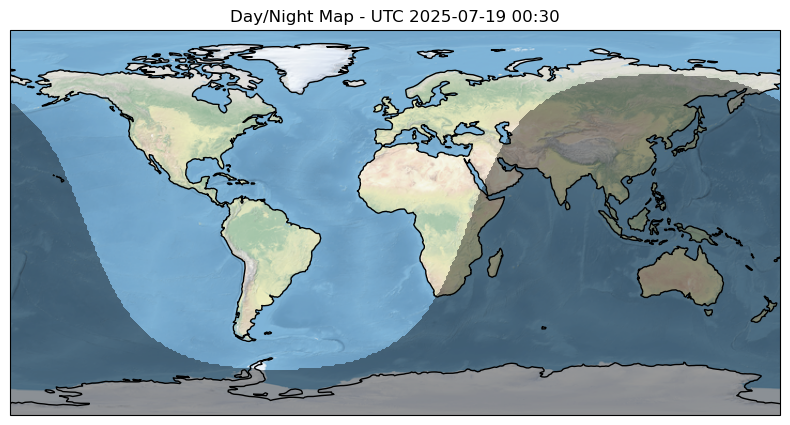

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import datetime, timezone

# Constants
DEG2RAD = math.pi / 180
RAD2DEG = 180 / math.pi

def day_of_year(date):
    return date.timetuple().tm_yday

def solar_declination(n):
    return 23.44 * math.sin(DEG2RAD * (360 / 365.0 * (n - 81)))

def greenwich_mean_sidereal_time(utc_datetime):
    days = (utc_datetime - datetime(2000, 1, 1, 12, tzinfo=timezone.utc)).total_seconds() / 86400.0
    GMST = 280.46061837 + 360.98564736629 * days
    return GMST % 360

def solar_elevation_angle(lat, lon, decl, gha):
    lat_rad = DEG2RAD * lat
    decl_rad = DEG2RAD * decl
    hour_angle = DEG2RAD * ((lon - gha + 360) % 360)
    sin_alpha = math.sin(lat_rad) * math.sin(decl_rad) + \
                math.cos(lat_rad) * math.cos(decl_rad) * math.cos(hour_angle)
    return RAD2DEG * math.asin(sin_alpha)

# Time
now = datetime.utcnow().replace(tzinfo=timezone.utc)
n = day_of_year(now)
decl = solar_declination(n)
gmst = greenwich_mean_sidereal_time(now)
gha = gmst  # Approximation: GHA = GMST

# Create lat/lon grid
lats = np.linspace(-90, 90, 180)
lons = np.linspace(-180, 180, 360)
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Compute solar elevation for each point
elevation_grid = np.vectorize(solar_elevation_angle)(lat_grid, lon_grid, decl, gha)

# Mask night areas (elevation < 0)
night_mask = elevation_grid < 0

# Plot with Cartopy
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()

# Overlay night shading
ax.contourf(lon_grid, lat_grid, night_mask, levels=[0.5, 1], colors='black', alpha=0.4, transform=ccrs.PlateCarree())

plt.title(f"Day/Night Map - UTC {now.strftime('%Y-%m-%d %H:%M')}")
plt.show()


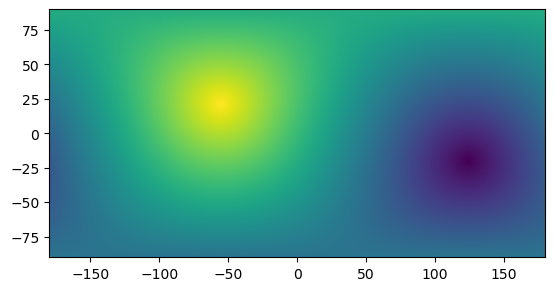

In [10]:
ax=plt.imshow(elevation_grid, extent=(-180, 180, -90, 90), cmap='viridis', origin='lower')

## This code below is for the Moon. 

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import datetime, timezone
from skyfield.api import load, wgs84

# Constants
DEG2RAD = math.pi / 180
RAD2DEG = 180 / math.pi

def moon_equatorial_coords(dt):
    """Returns RA, Dec of the Moon in degrees at UTC datetime dt."""
    ts = load.timescale()
    t = ts.utc(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    eph = load('de421.bsp')
    earth = eph['earth']
    moon = eph['moon']
    astrometric = earth.at(t).observe(moon)
    ra, dec, _ = astrometric.radec()
    return ra.hours * 15, dec.degrees  # RA in degrees, Dec in degrees

def greenwich_mean_sidereal_time(utc_datetime):
    days = (utc_datetime - datetime(2000, 1, 1, 12, tzinfo=timezone.utc)).total_seconds() / 86400.0
    GMST = 280.46061837 + 360.98564736629 * days
    return GMST % 360

def moon_elevation_angle(lat, lon, dec_moon, gha_moon):
    lat_rad = DEG2RAD * lat
    dec_rad = DEG2RAD * dec_moon
    hour_angle = DEG2RAD * ((lon - gha_moon + 360) % 360)
    sin_alpha = np.sin(lat_rad) * np.sin(dec_rad) + \
                np.cos(lat_rad) * np.cos(dec_rad) * np.cos(hour_angle)
    return RAD2DEG * np.arcsin(sin_alpha)

# --- Time & Moon position ---
now = datetime.utcnow().replace(tzinfo=timezone.utc)
ra_moon, dec_moon = moon_equatorial_coords(now)
gmst = greenwich_mean_sidereal_time(now)
gha_moon = (gmst - ra_moon) % 360  # GHA_moon = GMST - RA

# --- Grid ---
lats = np.linspace(-90, 90, 180)
lons = np.linspace(-180, 180, 360)
lon_grid, lat_grid = np.meshgrid(lons, lats)

# --- Moon elevation angle for each point ---
elevation_grid = moon_elevation_angle(lat_grid, lon_grid, dec_moon, gha_moon)

# --- Moonlight mask (moon above horizon) ---
moonlit_mask = elevation_grid > 0

# --- Plot ---
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()

# Overlay moonlight shading
ax.contourf(lon_grid, lat_grid, moonlit_mask, levels=[0.5, 1], colors='deepskyblue', alpha=0.35, transform=ccrs.PlateCarree())

plt.title(f"Moon Above Horizon (Moonlight) Map\nUTC {now.strftime('%Y-%m-%d %H:%M')}")
plt.show()


In [ ]:
ax=plt.imshow(elevation_grid, extent=(-180, 180, -90, 90), cmap='viridis', origin='lower')
